In [28]:
import sqlite3
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Download Data

In [2]:
#Create a connection to database
con=sqlite3.connect(os.path.realpath('../Data/attrition.db'))

In [3]:
df = pd.read_sql_query("SELECT * FROM attrition", con)

# Preprocess Data
## Step 1: Correlated columns

'Usage Time' is highly correlated to 'Usage Rate';

Generate a new column 'Hours per Week' to remove correlated columns

In [4]:
df['Hours per Week']=df['Usage Time']*df['Usage Rate']
df.drop(['Usage Time','Usage Rate'],axis=1, inplace=True)

In [5]:
df.head()

,Member Unique ID,Attrition,Age,Gender,Monthly Income,Travel Time,Qualification,Work Domain,Branch,Membership,Months,Birth Year,Hours per Week
0,1d172e75-2c13-4b73-a1da-18d442a10bf7,1,41,Female,5993,0.2 hours,Diploma,Engineering,Changi,Gold,7,1981,14
1,6dee0995-9ff1-44a6-b3f1-fc5f7270c8ab,0,49,Male,5130,0.7 hours,Diploma,Engineering,Thomson,Normal,11,1973,6
2,c9fff882-42e7-4e12-88ab-74aba95113dc,1,37,Male,2090,20.0 mins,Diploma,Medical,Thomson,Normal,1,1985,8
3,1521db93-82d8-46a8-9718-6acde2a7c001,0,33,Female,2909,20.0 mins,Master,Engineering,Thomson,Normal,9,1989,0
4,e8a69be8-c96a-4f37-b14c-b3c75aa32db3,0,27,Male,3468,0.3 hours,Diploma,Information Technology,Thomson,Normal,3,1995,15


## Step 2: Columns with inconsistent or invalid values:

### 2.1 Convert 'Travel Time' column with inconsistent units

In [6]:
# create a function to convert the 'Travel Time' from string with different units to numerical values in mins 
def cal_travel_time(x):
    if x.split()[1]=='mins':
        return int(float(x.split()[0]))
    else:
        return int(float(x.split()[0])*60)

In [7]:
# Apply the function cal_travel_time to column
df['Travel Time']=df['Travel Time'].apply(lambda x: cal_travel_time(x))

### 2.2 Convert 'Qualification' column with inconsistent cateogories

In [8]:
df['Qualification'].value_counts()

Bachelor                891
Diploma                 765
Master                  641
Ph.D                    100
Bachelor's               41
Master's                 27
Doctor of Philosophy      5
Name: Qualification, dtype: int64

In [9]:
# convert Bacheloar's into Bachelor; Convert 'Master's' into 'Master'; Convert "Doctor of Philosophy" to "Ph.D"
df['Qualification']=df['Qualification'].map(
    {'Bachelor':'Bachelor',
     'Master':'Master',
     'Ph.D':'Ph.D',
     'Diploma':'Diploma',
    
    "Bachelor's":'Bachelor',
     "Master's":'Master',
     'Doctor of Philosophy':'Ph.D'})

In [10]:
df['Qualification'].value_counts()

Bachelor    932
Diploma     765
Master      668
Ph.D        105
Name: Qualification, dtype: int64

### 2.3 Deal with invalid values in 'Monthly Income' columns

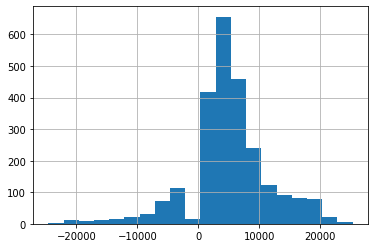

In [11]:
df['Monthly Income'].hist(bins=20)

In [12]:
df['Monthly Income']=abs(df['Monthly Income'])

### 2.4 Deal with negative value (-1) in 'Age' and 'Birth Year' columns

In [13]:
df['Age']=np.where(df['Age']>0, df['Age'], (2022-df['Birth Year']))

In [14]:
df.drop('Birth Year', axis=1, inplace=True)

### 2.5 Remove 'Member Unique ID' 

In [15]:
# This column does not hold meanings to Attrition
df.drop('Member Unique ID', axis=1, inplace=True)

## Step 3. Cateogrical data
### 3.1 Cateogorical Columns without order: 'Gender', 'Branch', 'Work Domain'

In [16]:
df=pd.get_dummies(df,columns=['Gender','Branch','Work Domain'],drop_first=True)

In [17]:
df

,Attrition,Age,Monthly Income,Travel Time,Qualification,Membership,Months,Hours per Week,Gender_Male,Branch_Kranji,Branch_Thomson,Work Domain_Engineering,Work Domain_Information Technology,Work Domain_Medical,Work Domain_Science,Work Domain_Unemployed
0,1,41,5993,12,Diploma,Gold,7,14,0,0,0,1,0,0,0,0
1,0,49,5130,42,Diploma,Normal,11,6,1,0,1,1,0,0,0,0
2,1,37,2090,20,Diploma,Normal,1,8,1,0,1,0,0,1,0,0
3,0,33,2909,20,Master,Normal,9,0,0,0,1,1,0,0,0,0
4,0,27,3468,18,Diploma,Normal,3,15,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,0,55,7168,24,Master,Bronze,10,15,1,0,0,0,0,1,0,0
2466,1,28,9138,53,Diploma,Normal,11,9,1,0,0,1,0,0,0,0
2467,0,55,11845,30,Master,Normal,4,15,1,0,1,1,0,0,0,0
2468,0,42,12579,31,Bachelor,Silver,5,2,0,0,0,0,0,0,0,0


### 3.2 Cateogorical Columns with order: Qualification, Membership

In [18]:
from sklearn.preprocessing import OrdinalEncoder

In [19]:
Qua_cat=['Diploma','Bachelor','Master','Ph.D']
Qua_enc = OrdinalEncoder(categories = [Qua_cat])
df[['Qualification']] = Qua_enc.fit_transform(df[['Qualification']])

Mem_cat=['Normal','Bronze','Silver','Gold']
Mem_enc = OrdinalEncoder(categories = [Mem_cat])
df[['Membership']] = Mem_enc.fit_transform(df[['Membership']])

In [20]:
Qua_enc.categories_

[array(['Diploma', 'Bachelor', 'Master', 'Ph.D'], dtype=object)]

In [21]:
Mem_enc.categories_

[array(['Normal', 'Bronze', 'Silver', 'Gold'], dtype=object)]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470 entries, 0 to 2469
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Attrition                           2470 non-null   int64  
 1   Age                                 2470 non-null   int64  
 2   Monthly Income                      2470 non-null   int64  
 3   Travel Time                         2470 non-null   int64  
 4   Qualification                       2470 non-null   float64
 5   Membership                          2470 non-null   float64
 6   Months                              2470 non-null   int64  
 7   Hours per Week                      2470 non-null   int64  
 8   Gender_Male                         2470 non-null   uint8  
 9   Branch_Kranji                       2470 non-null   uint8  
 10  Branch_Thomson                      2470 non-null   uint8  
 11  Work Domain_Engineering             2470 no

## Step 4. Feature Scaling of numerical columns

In [23]:
from sklearn.preprocessing import StandardScaler
df.columns

Index(['Attrition', 'Age', 'Monthly Income', 'Travel Time', 'Qualification',
       'Membership', 'Months', 'Hours per Week', 'Gender_Male',
       'Branch_Kranji', 'Branch_Thomson', 'Work Domain_Engineering',
       'Work Domain_Information Technology', 'Work Domain_Medical',
       'Work Domain_Science', 'Work Domain_Unemployed'],
      dtype='object')

In [24]:
num_attribs=['Age', 'Monthly Income', 'Travel Time', 'Months', 'Hours per Week']
scaler = StandardScaler()
df[num_attribs]=scaler.fit_transform(df[num_attribs])

# Train Test Split

In [27]:
X=df.drop('Attrition',axis=1)
y=df['Attrition']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Train models

## 1. Logistic Model

In [29]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_res,y_res)
logr_prediction=logr.predict(X_test)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test,logr_prediction))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       609
           1       0.22      0.38      0.28       132

    accuracy                           0.65       741
   macro avg       0.53      0.54      0.52       741
weighted avg       0.73      0.65      0.68       741



##  2. Random Forest Model

In [33]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_res,y_res)
rfc_predictions = rfc.predict(X_test)
print(classification_report(y_test,rfc_predictions))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       609
           1       0.34      0.22      0.27       132

    accuracy                           0.79       741
   macro avg       0.59      0.56      0.57       741
weighted avg       0.75      0.79      0.77       741



In [34]:
from sklearn.model_selection import GridSearchCV
param_grid=[
    {
        'n_estimators': [200,400,600,800],
        'max_features':[4,6,8,10]
    }
]
gs_rfc=RandomForestClassifier()
grid_search=GridSearchCV(gs_rfc, param_grid, cv=5,scoring='f1_micro',return_train_score=True)
grid_search.fit(X_res,y_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [4, 6, 8, 10],
                          'n_estimators': [200, 400, 600, 800]}],
             return_train_score=True, scoring='f1_micro')

In [ ]:
final_model=grid_search.best_estimator_
final_prediction=final_model.predict(X_test)
print(classification_report(y_test,final_prediction))

## 3. LightGBM Model

In [ ]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_res, y_res)
lgb_predictions=clf.predict(X_test)
print(classification_report(y_test,lgb_predictions))

## 4. SGDClassifier Model

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_res,y_res)
sgd_predictions=clf.predict(X_test)
print(classification_report(y_test,sgd_predictions))